# 4.1 Convolutional neural networks
## 4.1.1 Convolutional filters
- Unlike a regular feed-forward neural network whose neurons are arranged in flat, fully connected layers, layers in a ConvNet are arranged in three dimensions (width * height * depth).
- Each filter has a relatively small receptive field (width * height) but always extends through the entire depth of the input volume.
 - filterのdepthはいつもinputのdepthと一緒。例えば、もし入力画像が3 channelsだったら、filterのdepthも3です。そうすると、filterの数が新しいconv layerのdepthになれる。

# 4.3 Batch Normalization
- アルゴリズム
 - 参考：https://arxiv.org/abs/1502.03167
 - <img src="img/batch-normalization-2020-02-22 20-36-16.png" width="400">
- Normalizationの定義
 - Normalization is the scaling of data so that it has zero mean and unit variance.
- 違うscaleの例
 - 家族の月支出（ししゅつ）を予測する。２つfeatureを考える：年次所得、家族人数。
 - The scales of these features are vastly different - an extra 10 dollars in annual income probably wouldn't influence how much a family spends, but an additional 10 members would likely wreak havoc on any family's budget.
- 一番大事な理解すべきことはbatch normalizationの対象。
 - 参考：https://stackoverflow.com/questions/38553927/batch-normalization-in-convolutional-neural-network
 - hidden layerのサイズは[B, H, W, C]です。B:batch size, C:number of channels, [H,W]:feature map size.
 - 基本的にはbatch_sizeに対して平均値や標準偏差を取る。
     - $mean = mean(layer, axis=0)$
     - $stddev = stddev(layer, axis=0)$
     - つまりmeanやstddevのサイズは[H, W, C]です。
 - しかしConvNetの場合、filterのparameterがシェアされるので、[B,H,W]に対して平均値や標準偏差を取る。
     - $mean = mean(layer, axis=(0,1,2))$
     - $stddev = stddev(layer, axis=(0,1,2))$
     - つまりmeanやstddevのサイズは[C]になる。
- Batch Normalizationのメリット
 - Batch normalization limits the amount by which updating the parameters in the previous layers can affect the distribution of inputs received by the current layer.
 - This decreases any **unwanted interdependence between parameters across layers**.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

# Step 1: Generator

In [3]:
def build_generator(z_dim):
    model = Sequential()
    
    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(7 * 7 * 256, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    
    # Transposed convolution layer, from 7x7x256 to 14x14x128 tensor. filter数は128になる。
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization()) # convolution layerとactivationの間にbatch normalizationが行う。
    model.add(LeakyReLU(alpha=0.01))
    
    # from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    # from 14x14x64 to 28x28x1 tensor. mnist画像のサイズにする。
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    return model

# Step 2: Discriminator

In [5]:
def build_discriminator(img_shape):
    model = Sequential()
    
    # img_shape to 14x14x32. 
    # Conv2D: when using this layer as the first layer in a model, provide the keyword argument 'input shape'
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    # from 14x14x32 to 7x7x64.
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    # from 7x7x64 to 3x3x128.ぴったり2倍じゃないけど。
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Step 3: build and compile DiscriminatorやGAN

In [7]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [9]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])
generator = build_generator(z_dim)
discriminator.trainable = False
gan = build_gan(generator=generator, discriminator=discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# Step 4: Training and sampling function

In [18]:
def sample_images(generator, image_grid_rows=4, image_grid_cols=4):
    z = np.random.normal(0.0, 1.0, (image_grid_rows * image_grid_cols, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(nrows=image_grid_rows,
                           ncols=image_grid_cols,
                           figsize=(4, 4),
                           sharex=True,
                           sharey=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

In [22]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        # Discriminator training
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        
        z = np.random.normal(0.0, 1.0, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Generator training
        z = np.random.normal(0.0, 1.0, (batch_size, z_dim))
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:
            gan.save_weights('gan.h5')
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            print("%d [D loss: %f, accuracy: %.2f%%] [G loss: %f]" %
                 (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            sample_images(generator)

# Step 5: Train the model and inspect output

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.078822, accuracy: 99.61%] [G loss: 2.601076]
2000 [D loss: 0.166979, accuracy: 94.14%] [G loss: 3.353083]
3000 [D loss: 0.162399, accuracy: 96.09%] [G loss: 3.380371]
4000 [D loss: 0.171931, accuracy: 92.19%] [G loss: 4.499295]
5000 [D loss: 0.037518, accuracy: 99.61%] [G loss: 4.465166]
6000 [D loss: 0.070973, accuracy: 98.83%] [G loss: 3.546611]
7000 [D loss: 0.073009, accuracy: 99.61%] [G loss: 4.311448]
8000 [D loss: 0.018706, accuracy: 100.00%] [G loss: 4.675330]
9000 [D loss: 0.040010, accuracy: 100.00%] [G loss: 5.909271]
10000 [D loss: 0.047513, accuracy: 98.83%] [G loss: 2.520833]
11000 [D loss: 0.071206, accuracy: 97.66%] [G loss: 3.746932]
12000 [D loss: 0.025694, accuracy: 100.00%] [G loss: 7.716067]
13000 [D loss: 0.016099, accuracy: 100.00%] [G loss: 5.207755]
14000 [D loss: 0.135701, accuracy: 96.09%] [G loss: 4.541829]
15000 [D loss: 0.111449, accuracy: 96.88%] [G loss: 4.029686]
16000 [D loss: 0.024062, accuracy: 100.00%] [G loss: 5.733377]
17000 [D los

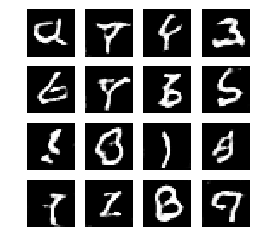

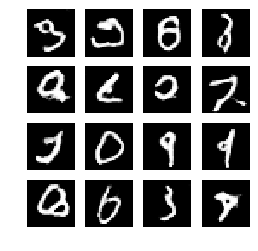

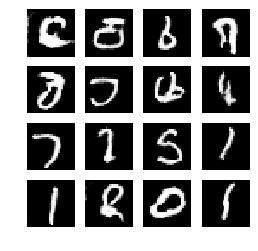

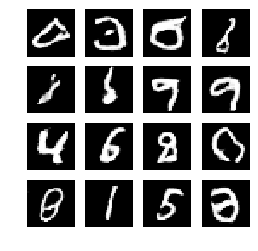

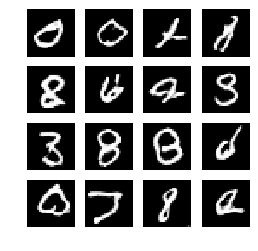

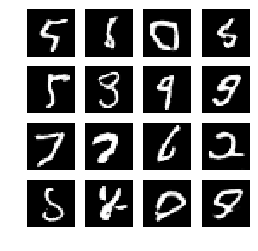

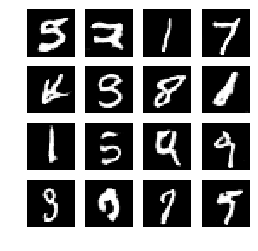

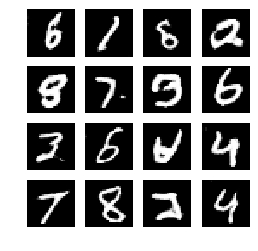

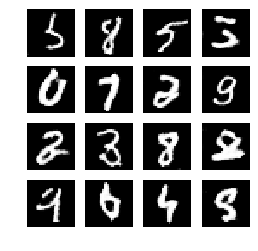

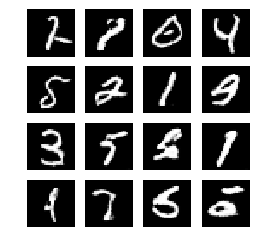

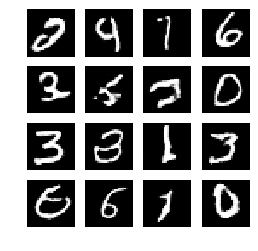

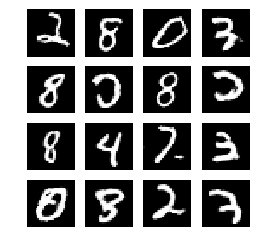

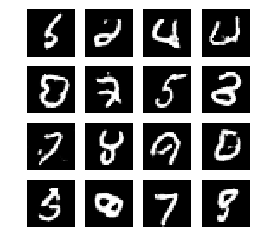

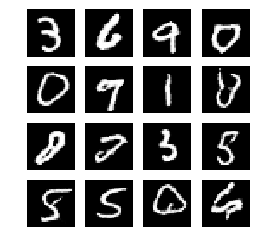

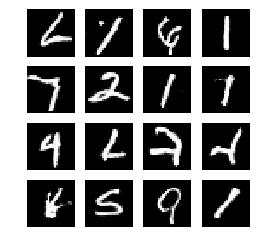

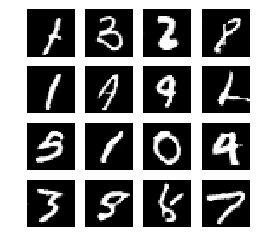

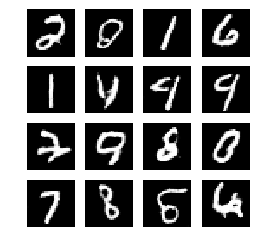

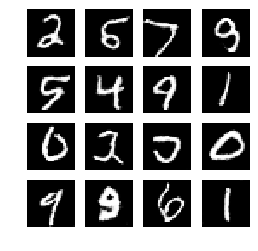

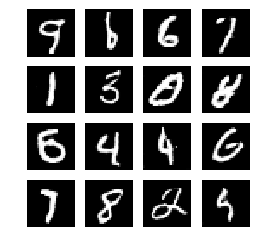

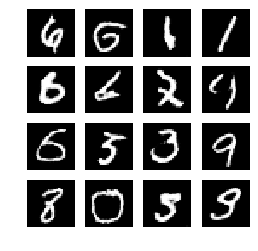

In [23]:
%time
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations=iterations, batch_size=batch_size, sample_interval=sample_interval)

- GPUを使ったけど、結構時間かかった。約1時間。
- Discriminatorのaccuracyはまだ100%。Generatorはまだ全然弱くて、50%のaccuracyは夢見たい。。。
- こんな大変なトレーニングで、絶対学習済みnetworkのweightsを保存した方がいい。